In [1]:
!pip install statsforecast skforecast --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.5 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from pmdarima import auto_arima
from statsforecast.models import AutoARIMA, AutoETS, Naive, ARIMA
import warnings

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False
    print("WARNING: 'prophet' library not found. The Prophet section will be skipped.")
    print("Install it via: pip install prophet")

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Install it via: pip install prophet


In [2]:
# --- 1. DATA LOADING & CLEANING ---

df = pd.read_csv('data/clean_data.csv')

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')

# Set time as index for easier plotting and manipulation
df.set_index('time', inplace=True)

# Filter for data where we actually have PM2.5
df_model = df.dropna(subset=['aqi_pm25']).copy()

print(f"Original Data Range: {df.index.min()} to {df.index.max()}")
print(f"Modeling Data Range: {df_model.index.min()} to {df_model.index.max()}")
print(f"Total samples for modeling: {len(df_model)}")

Original Data Range: 2022-08-05 07:00:00 to 2025-11-19 23:00:00
Modeling Data Range: 2022-08-05 07:00:00 to 2025-11-19 23:00:00
Total samples for modeling: 28865


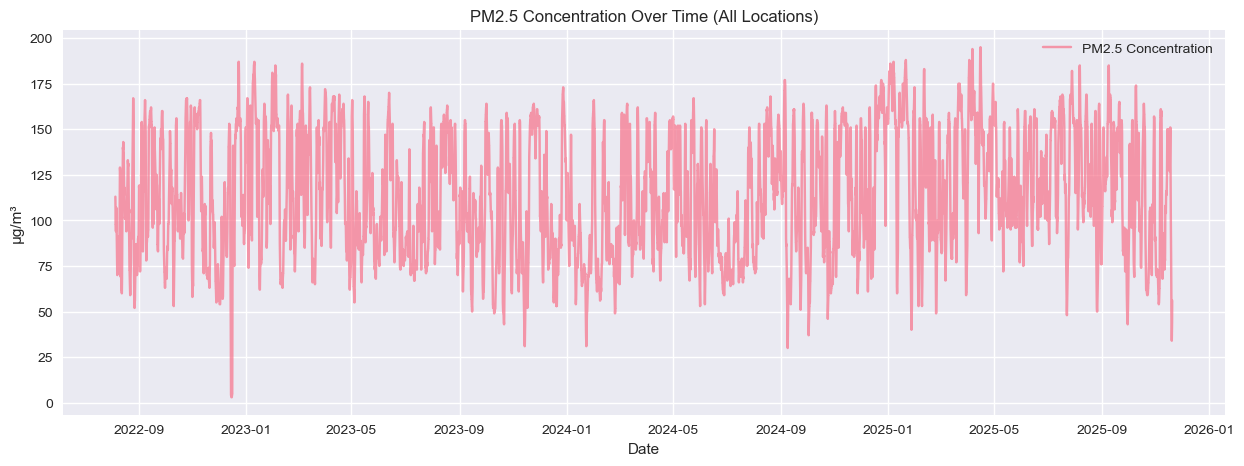

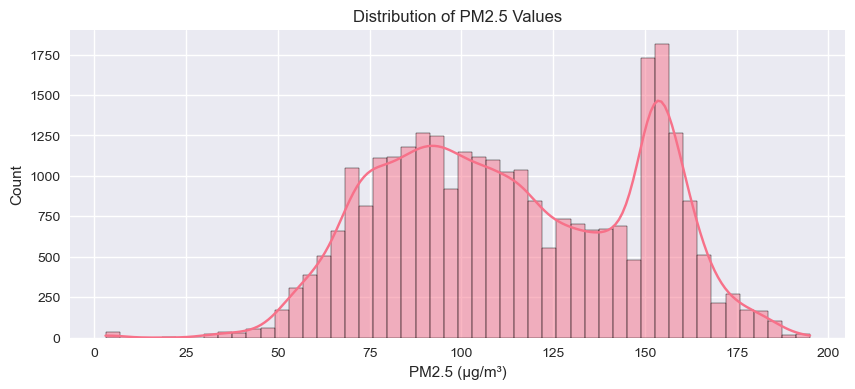

In [3]:
# --- 2. BASIC EDA ---

# Plot the Target Variable (PM2.5)
plt.figure(figsize=(15, 5))
plt.plot(df_model.index, df_model['aqi_pm25'], label='PM2.5 Concentration', alpha=0.7)
plt.title('PM2.5 Concentration Over Time (All Locations)')
plt.ylabel('µg/m³')
plt.xlabel('Date')
plt.legend()
plt.show()

# Check Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df_model['aqi_pm25'], kde=True, bins=50)
plt.title('Distribution of PM2.5 Values')
plt.xlabel('PM2.5 (µg/m³)')
plt.show()

In [5]:
print(df_model.columns)

Index(['temperature_2m', 'relative_humidity_2m', 'rain', 'wind_direction_10m',
       'wind_speed_10m', 'aqi_pm25', 'hour', 'month', 'day_of_week',
       'is_weekend', 'is_raining'],
      dtype='object')


In [3]:
# --- 3. FEATURE ENGINEERING ---
def get_aqi_category(aqi):
    """Returns the textual category for a given AQI value (US Standard)."""
    if aqi is None or np.isnan(aqi):
        return None
    
    val = int(aqi)
    if val <= 50: return "Good"
    if val <= 100: return "Moderate"
    if val <= 150: return "Unhealthy for Sensitive Groups"
    if val <= 200: return "Unhealthy"
    if val <= 300: return "Very Unhealthy"
    return "Hazardous"
    
def engineer_features_multistep(data):
    """
    Prepares data for multi-step forecasting (t+1 to t+24).
    Row 't' will contain:
      - X: Weather(t), Time(t), PM25(t), PM25(t-1)...
      - y: PM25(t+1), PM25(t+2)... PM25(t+24)
    """
    df_eng = data.copy()
    
    # Location encoding if existed
    if 'lat' in df_eng.columns and 'lon' in df_eng.columns:
        df_eng['loc_id'] = df_eng['lat'].astype(str) + '_' + df_eng['lon'].astype(str)
        loc_dummies = pd.get_dummies(df_eng['loc_id'], prefix='loc')
        loc_dummies = loc_dummies.astype(int)
        df_eng = pd.concat([df_eng, loc_dummies], axis=1)
        loc_features = loc_dummies.columns.tolist()
    else:
        loc_features = []

    # Wind direction (Handle multiple naming conventions)
    wind_col = None
    for col_name in ['wind_dir', 'wind_direction_10m']:
        if col_name in df_eng.columns:
            wind_col = col_name
            break
            
    if wind_col and 'wind_sin' not in df_eng.columns:
        df_eng['wind_sin'] = np.sin(np.deg2rad(df_eng[wind_col]))
        df_eng['wind_cos'] = np.cos(np.deg2rad(df_eng[wind_col]))

    # encode month and day_of_week as integers
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    dow_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
        'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }

    df_eng['month'] = df_eng['month'].map(month_map).astype(int)
    df_eng['day_of_week'] = df_eng['day_of_week'].map(dow_map).astype(int)
    df_eng['is_raining'] = df_eng['is_raining'].astype(bool)
    df_eng['is_weekend'] = df_eng['is_weekend'].astype(bool)
    
    # Define lag periods up to 24 hours
    lags = [1, 3, 6, 12, 24]
    
    # Variables to create lag features for
    lag_variables = ['aqi_pm25', 'wind_speed_10m', 'is_raining', 
                     'relative_humidity_2m', 'temperature_2m', 'wind_sin', 'wind_cos']
    
    # Create lag features for each variable
    lag_feats = []
    for var in lag_variables:
        if var in df_eng.columns:
            for lag in lags:
                col_name = f'{var}_lag{lag}'
                df_eng[col_name] = df_eng[var].shift(lag)
                # Keep is_raining lag features as bool
                if var == 'is_raining':
                    df_eng[col_name] = df_eng[col_name].astype('boolean')
                lag_feats.append(col_name)
        
    # Rolling Stats for PM2.5
    target_var = 'aqi_pm25'
    df_eng['aqi_pm25_roll_mean_24h'] = df_eng[target_var].shift(1).rolling(window=24).mean()
    
    # TARGETS
    H = 24
    target_cols = []
    for h in range(1, H+1):
        col_name = f'{target_var}_t+{h}'
        df_eng[col_name] = df_eng[target_var].shift(-h)
        target_cols.append(col_name)

    # Cleanup
    df_eng.dropna(inplace=True)
    
    # Convert boolean columns back to bool after dropna (nullable boolean -> regular bool)
    for col in df_eng.columns:
        if 'is_raining' in col:
            df_eng[col] = df_eng[col].astype(bool)
    
    # FEATURE SELECTION
    # Current weather values (not lagged)
    possible_weather = ['aqi_pm25',
        # Dataset 1 styles
        'temp', 'pres', 'wind_spd', 'wind_gust_spd', 'precip', 'humidity', 'no2', 'so2', 'co',
        # Dataset 2 styles
        'temperature_2m', 'relative_humidity_2m', 'is_raining', 'wind_speed_10m', 'wind_sin', 'wind_cos'
    ]
    weather_feats = [c for c in possible_weather if c in df_eng.columns]

    # Base Time features for trees
    time_orig_feats = ['hour', 'month', 'day_of_week']
    
    # Full Input List (weather + lags + rolling + location)
    X_cols = weather_feats + lag_feats + ['aqi_pm25_roll_mean_24h'] + loc_features
    
    # No engineered time features (removed sin/cos)
    time_eng_feats = []
    
    return df_eng, X_cols, target_cols, time_orig_feats, time_eng_feats

df_processed, X_cols, target_cols, time_orig_cols, time_eng_cols = engineer_features_multistep(df_model)
X = df_processed[X_cols + time_eng_cols]
y = df_processed[target_cols]
print(f"Data shape before engineering: {df_model.shape}")
print(f"Data shape after engineering: {df_processed.shape}")
print(f"\nTotal features: {len(X_cols + time_eng_cols)}")
print(f"Features: {X_cols + time_eng_cols}")

# Verify is_raining columns are bool
raining_cols = [c for c in X.columns if 'is_raining' in c]
print(f"\nis_raining column types:")
for col in raining_cols:
    print(f"  {col}: {X[col].dtype}")

Data shape before engineering: (28865, 11)
Data shape after engineering: (28817, 73)

Total features: 43
Features: ['aqi_pm25', 'temperature_2m', 'relative_humidity_2m', 'is_raining', 'wind_speed_10m', 'wind_sin', 'wind_cos', 'aqi_pm25_lag1', 'aqi_pm25_lag3', 'aqi_pm25_lag6', 'aqi_pm25_lag12', 'aqi_pm25_lag24', 'wind_speed_10m_lag1', 'wind_speed_10m_lag3', 'wind_speed_10m_lag6', 'wind_speed_10m_lag12', 'wind_speed_10m_lag24', 'is_raining_lag1', 'is_raining_lag3', 'is_raining_lag6', 'is_raining_lag12', 'is_raining_lag24', 'relative_humidity_2m_lag1', 'relative_humidity_2m_lag3', 'relative_humidity_2m_lag6', 'relative_humidity_2m_lag12', 'relative_humidity_2m_lag24', 'temperature_2m_lag1', 'temperature_2m_lag3', 'temperature_2m_lag6', 'temperature_2m_lag12', 'temperature_2m_lag24', 'wind_sin_lag1', 'wind_sin_lag3', 'wind_sin_lag6', 'wind_sin_lag12', 'wind_sin_lag24', 'wind_cos_lag1', 'wind_cos_lag3', 'wind_cos_lag6', 'wind_cos_lag12', 'wind_cos_lag24', 'aqi_pm25_roll_mean_24h']

is_raini

In [4]:
print(X.columns)
print(y.columns)

Index(['aqi_pm25', 'temperature_2m', 'relative_humidity_2m', 'is_raining',
       'wind_speed_10m', 'wind_sin', 'wind_cos', 'aqi_pm25_lag1',
       'aqi_pm25_lag3', 'aqi_pm25_lag6', 'aqi_pm25_lag12', 'aqi_pm25_lag24',
       'wind_speed_10m_lag1', 'wind_speed_10m_lag3', 'wind_speed_10m_lag6',
       'wind_speed_10m_lag12', 'wind_speed_10m_lag24', 'is_raining_lag1',
       'is_raining_lag3', 'is_raining_lag6', 'is_raining_lag12',
       'is_raining_lag24', 'relative_humidity_2m_lag1',
       'relative_humidity_2m_lag3', 'relative_humidity_2m_lag6',
       'relative_humidity_2m_lag12', 'relative_humidity_2m_lag24',
       'temperature_2m_lag1', 'temperature_2m_lag3', 'temperature_2m_lag6',
       'temperature_2m_lag12', 'temperature_2m_lag24', 'wind_sin_lag1',
       'wind_sin_lag3', 'wind_sin_lag6', 'wind_sin_lag12', 'wind_sin_lag24',
       'wind_cos_lag1', 'wind_cos_lag3', 'wind_cos_lag6', 'wind_cos_lag12',
       'wind_cos_lag24', 'aqi_pm25_roll_mean_24h'],
      dtype='object')
Inde

In [5]:
X_with_target = X.copy()

target = 'aqi_pm25_t+1'
X_with_target[target] = y[target]

corr_matrix = X_with_target.corr()

# plt.figure(figsize=(15, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.show()

In [6]:
# Feature selection based on correlation threshold
threshold = 0.1

corr_matrix.drop(time_eng_cols, inplace=True)

corr_with_target = corr_matrix.get(target, pd.Series()).abs()
selected_features = corr_with_target[corr_with_target > threshold].sort_values(ascending=False).index.tolist()
selected_features = [f for f in selected_features if f != target]

# Fallback to manual list if nothing selected
if not selected_features:
    selected_features = X_cols

features_str = '\n'.join(selected_features)
print(f"Selected {len(selected_features)} features with |corr| > {threshold}:\n{features_str}")

Selected 23 features with |corr| > 0.1:
aqi_pm25
aqi_pm25_lag1
aqi_pm25_lag3
aqi_pm25_lag6
aqi_pm25_roll_mean_24h
aqi_pm25_lag12
aqi_pm25_lag24
wind_speed_10m_lag12
wind_speed_10m_lag24
wind_speed_10m_lag6
wind_speed_10m_lag3
wind_speed_10m_lag1
wind_speed_10m
is_raining_lag24
is_raining_lag12
is_raining_lag6
is_raining_lag3
is_raining_lag1
is_raining
wind_cos_lag6
wind_cos_lag3
wind_cos_lag1
wind_cos


In [7]:
# Chronological Split (80/20)
split_idx = int(len(df_processed) * 0.8)
train_df = df_processed.iloc[:split_idx]
test_df = df_processed.iloc[split_idx:]

X_train = train_df[selected_features + time_eng_cols]
y_train = train_df[target_cols]
X_test = test_df[selected_features + time_eng_cols]
y_test = test_df[target_cols]

X_train_tree = train_df[selected_features + time_orig_cols]
X_test_tree = test_df[selected_features + time_orig_cols]

print(f"Train Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")
print(f"Target Shape: {y_train.shape}")
print(f"Test Start Date: {test_df.index.min()}")
print(f"\nInput features: {X_test.columns}")

Train Set Shape: (23053, 23)
Test Set Shape: (5764, 23)
Target Shape: (23053, 24)
Test Start Date: 2025-03-23 20:00:00

Input features: Index(['aqi_pm25', 'aqi_pm25_lag1', 'aqi_pm25_lag3', 'aqi_pm25_lag6',
       'aqi_pm25_roll_mean_24h', 'aqi_pm25_lag12', 'aqi_pm25_lag24',
       'wind_speed_10m_lag12', 'wind_speed_10m_lag24', 'wind_speed_10m_lag6',
       'wind_speed_10m_lag3', 'wind_speed_10m_lag1', 'wind_speed_10m',
       'is_raining_lag24', 'is_raining_lag12', 'is_raining_lag6',
       'is_raining_lag3', 'is_raining_lag1', 'is_raining', 'wind_cos_lag6',
       'wind_cos_lag3', 'wind_cos_lag1', 'wind_cos'],
      dtype='object')


In [8]:
def evaluate_multi_step(name, y_true, y_pred):
    """
    Evaluates multi-step forecasts and prints a formatted table.
    Dynamically handles inputs with fewer than 24 columns (e.g. only t+1).
    
    y_true: numpy array/DataFrame of shape (n_samples, n_horizons)
    y_pred: numpy array/DataFrame of shape (n_samples, n_horizons)
    """
    
    # 1. Convert to Numpy
    if hasattr(y_true, 'values'):
        y_true = y_true.values
    if hasattr(y_pred, 'values'):
        y_pred = y_pred.values
        
    # 2. Handle 1D inputs (Shape N,) -> Reshape to (N, 1)
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    # 3. Determine available columns based on Prediction input
    # We assume y_true corresponds to y_pred (or has at least as many cols)
    num_cols = y_pred.shape[1]
        
    # Define the horizons we want to report
    horizons = [1, 2, 3, 6, 12, 24]
    
    # Header Formatting
    header = f"{'Metric':<10} |"
    for h in horizons:
        header += f" {'t+'+str(h):<8} |"
    header += f" {'Overall':<8}"
    
    print(f"\n--- {name} Performance ---")
    print("-" * len(header))
    print(header)
    print("-" * len(header))
    
    # 4. Calculate Per-Step Metrics
    step_results = {}
    
    for h in horizons:
        col_idx = h - 1
        
        # Only calculate if we have data for this horizon
        if col_idx < num_cols:
            # Safely slice both arrays
            # (Assumes y_true has at least as many columns as y_pred)
            if col_idx < y_true.shape[1]:
                true_col = y_true[:, col_idx]
                pred_col = y_pred[:, col_idx]
                
                rmse = np.sqrt(mean_squared_error(true_col, pred_col))
                mae = mean_absolute_error(true_col, pred_col)
                r2 = r2_score(true_col, pred_col)
                
                step_results[h] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
            else:
                 # y_pred has col but y_true doesn't (mismatch)
                 step_results[h] = None
        else:
            # Horizon beyond what was predicted
            step_results[h] = None

    # 5. Calculate Overall Metrics (Average across valid columns)
    # We limit y_true to the same number of columns as y_pred for fairness
    if num_cols > 0:
        y_true_sliced = y_true[:, :num_cols]
        y_pred_sliced = y_pred[:, :num_cols]
        
        overall_rmse = np.sqrt(mean_squared_error(y_true_sliced, y_pred_sliced))
        overall_mae = mean_absolute_error(y_true_sliced, y_pred_sliced)
        overall_r2 = r2_score(y_true_sliced, y_pred_sliced)
    else:
        overall_rmse = overall_mae = overall_r2 = None

    # 6. Print Rows
    for metric_name in ['RMSE', 'MAE', 'R2']:
        row_str = f"{metric_name:<10} |"
        
        for h in horizons:
            val = step_results.get(h)
            
            if val is not None:
                # Format actual numbers
                fmt = "<8.3f" if metric_name == 'R2' else "<8.2f"
                row_str += f" {val[metric_name]:{fmt}} |"
            else:
                # Format empty cell
                row_str += f" {'-':<8} |"
        
        # Add Overall column
        if overall_rmse is not None:
            val = overall_r2 if metric_name == 'R2' else (overall_rmse if metric_name == 'RMSE' else overall_mae)
            fmt = "<8.3f" if metric_name == 'R2' else "<8.2f"
            row_str += f" {val:{fmt}}"
        else:
            row_str += f" {'-':<8}"
            
        print(row_str)
    print("-" * len(header))

In [9]:
def get_aqi_category_vectorized(aqi_values):
    """
    Vectorized conversion of AQI values to category indices.
    Categories: 0=Good, 1=Moderate, 2=Unhealthy for Sensitive Groups,
                3=Unhealthy, 4=Very Unhealthy, 5=Hazardous
    """
    aqi = np.asarray(aqi_values)
    categories = np.zeros_like(aqi, dtype=int)
    categories[aqi > 50] = 1   # Moderate
    categories[aqi > 100] = 2  # Unhealthy for Sensitive Groups
    categories[aqi > 150] = 3  # Unhealthy
    categories[aqi > 200] = 4  # Very Unhealthy
    categories[aqi > 300] = 5  # Hazardous
    return categories

def evaluate_category_accuracy(name, y_true, y_pred):
    """
    Evaluates multi-step forecasts based on AQI category accuracy.
    Prints a formatted table showing category accuracy at different horizons.
    
    y_true: numpy array/DataFrame of shape (n_samples, n_horizons)
    y_pred: numpy array/DataFrame of shape (n_samples, n_horizons)
    """
    # Convert to Numpy
    if hasattr(y_true, 'values'):
        y_true = y_true.values
    if hasattr(y_pred, 'values'):
        y_pred = y_pred.values
        
    # Handle 1D inputs
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    num_cols = y_pred.shape[1]
    horizons = [1, 2, 3, 6, 12, 24]
    
    # Convert to categories
    true_cats = get_aqi_category_vectorized(y_true)
    pred_cats = get_aqi_category_vectorized(y_pred)
    
    # Header
    header = f"{'Metric':<12} |"
    for h in horizons:
        header += f" {'t+'+str(h):<8} |"
    header += f" {'Overall':<8}"
    
    print(f"\n--- {name} Category Accuracy ---")
    print("-" * len(header))
    print(header)
    print("-" * len(header))
    
    # Calculate per-step accuracy
    step_results = {}
    for h in horizons:
        col_idx = h - 1
        if col_idx < num_cols and col_idx < y_true.shape[1]:
            correct = (true_cats[:, col_idx] == pred_cats[:, col_idx]).sum()
            total = len(true_cats[:, col_idx])
            step_results[h] = correct / total * 100
        else:
            step_results[h] = None
    
    # Overall accuracy
    if num_cols > 0:
        true_cats_sliced = true_cats[:, :num_cols]
        pred_cats_sliced = pred_cats[:, :num_cols]
        overall_acc = (true_cats_sliced == pred_cats_sliced).sum() / true_cats_sliced.size * 100
    else:
        overall_acc = None
    
    # Print accuracy row
    row_str = f"{'Accuracy %':<12} |"
    for h in horizons:
        val = step_results.get(h)
        if val is not None:
            row_str += f" {val:<8.2f} |"
        else:
            row_str += f" {'-':<8} |"
    
    if overall_acc is not None:
        row_str += f" {overall_acc:<8.2f}"
    else:
        row_str += f" {'-':<8}"
    
    print(row_str)
    print("-" * len(header))
    
    return step_results, overall_acc

### Baseline: Persistence

In [12]:
# 0. Baseline: Persistence Model (Naive Forecast)
# Prediction for t+n is simply the value at t
y_pred_persist = np.tile(X_test['aqi_pm25_lag1'].values.reshape(-1, 1), (1, 24))
evaluate_multi_step('Persistence (Baseline)', y_test, y_pred_persist)


--- Persistence (Baseline) Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 3.72     | 5.45     | 7.12     | 11.65    | 18.99    | 29.44    | 20.02   
MAE        | 2.46     | 3.64     | 4.79     | 8.03     | 13.75    | 22.58    | 13.61   
R2         | 0.986    | 0.970    | 0.949    | 0.863    | 0.639    | 0.142    | 0.601   
---------------------------------------------------------------------------------------


### Linear Regression

In [ ]:
# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
evaluate_multi_step('Linear Regression', y_test, y_pred_lr)


--- Linear Regression Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 1.25     | 2.23     | 3.42     | 7.12     | 13.65    | 23.08    | 14.82   
MAE        | 0.86     | 1.51     | 2.32     | 4.94     | 9.97     | 18.27    | 9.96    
R2         | 0.998    | 0.995    | 0.988    | 0.949    | 0.813    | 0.472    | 0.781   
---------------------------------------------------------------------------------------


In [25]:
print(y_pred_lr)

[[163.96724364 162.79047368 161.53160502 ... 134.48151776 133.31115087
  132.28319163]
 [162.92707315 161.84987521 160.76090856 ... 137.39247979 136.41226608
  135.47817108]
 [161.9121584  160.80430456 159.66371633 ... 136.24302117 135.29722431
  134.39708905]
 ...
 [ 62.28487197  58.93014081  55.89315713 ...  42.40380436  44.2591201
   46.22451011]
 [ 58.56888345  55.45112517  52.69216608 ...  46.12009266  47.99280195
   50.00952444]
 [ 56.28651061  53.92206423  51.79734136 ...  47.52608503  49.38456471
   51.25670847]]


### XGBoost

In [14]:
# 2.1. XGBoost
print("\n--- Starting Hyperparameter Tuning ---")
print("Go grab a drink as this may take a few minutes...")

# Define the parameter grid
param_dist = {
    'n_estimators': [500, 1000],            # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # Step size
    'max_depth': [3, 5, 7, 9],              # Tree depth (prevent overfitting)
    'subsample': [0.7, 0.8, 0.9],           # % of data used per tree
    'colsample_bytree': [0.7, 0.8, 0.9],    # % of features used per tree
    'min_child_weight': [1, 3, 5]           # helps prevent over-fitting on noise
}

# Base model
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# TimeSeriesSplit ensures we don't shuffle data during Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# Randomized Search (faster than Grid Search)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_tree, y_train['aqi_pm25_t+1'])

best_params = random_search.best_params_
print(f"\nBest Parameters Found: {best_params}")

# Train with best params
best_xgb = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

best_xgb.fit(
    X_train_tree, y_train,
    eval_set=[(X_test_tree, y_test)],
    verbose=False
)


--- Starting Hyperparameter Tuning ---
Go grab a drink as this may take a few minutes...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters Found: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}

Best Parameters Found: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
y_pred_xgb = best_xgb.predict(X_test_tree)
evaluate_multi_step('XGBoost', y_test, y_pred_xgb)


--- XGBoost Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 1.39     | 2.45     | 3.61     | 7.33     | 13.65    | 24.10    | 15.27   
MAE        | 0.98     | 1.74     | 2.58     | 5.29     | 10.17    | 19.30    | 10.46   
R2         | 0.998    | 0.994    | 0.987    | 0.946    | 0.813    | 0.425    | 0.768   
---------------------------------------------------------------------------------------


In [16]:
# 2.1.1. XGBoost with engineered time features
print("\n--- Starting Hyperparameter Tuning ---")
print("Go grab a drink as this may take a few minutes...")

# Define the parameter grid
param_dist = {
    'n_estimators': [500, 1000],            # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # Step size
    'max_depth': [3, 5, 7, 9],              # Tree depth (prevent overfitting)
    'subsample': [0.7, 0.8, 0.9],           # % of data used per tree
    'colsample_bytree': [0.7, 0.8, 0.9],    # % of features used per tree
    'min_child_weight': [1, 3, 5]           # helps prevent over-fitting on noise
}

# Base model
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# TimeSeriesSplit ensures we don't shuffle data during Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# Randomized Search (faster than Grid Search)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train['aqi_pm25_t+1'])

best_params = random_search.best_params_
print(f"\nBest Parameters Found: {best_params}")

# Train with best params
best_xgb = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)


--- Starting Hyperparameter Tuning ---
Go grab a drink as this may take a few minutes...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters Found: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}

Best Parameters Found: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
y_pred_xgb = best_xgb.predict(X_test)
evaluate_multi_step('XGBoost', y_test, y_pred_xgb)


--- XGBoost Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 1.39     | 2.55     | 4.01     | 7.53     | 14.15    | 24.23    | 15.49   
MAE        | 0.98     | 1.81     | 2.87     | 5.46     | 10.64    | 19.18    | 10.61   
R2         | 0.998    | 0.993    | 0.984    | 0.943    | 0.800    | 0.419    | 0.761   
---------------------------------------------------------------------------------------


### Random Forest

In [18]:
# 2.2. Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_tree, y_train)

RandomForestRegressor(max_depth=25, min_samples_leaf=2, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [19]:
y_pred_rf = rf.predict(X_test_tree)
evaluate_multi_step('Random Forest', y_test, y_pred_rf)


--- Random Forest Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 2.05     | 3.01     | 4.13     | 7.67     | 14.24    | 24.58    | 15.75   
MAE        | 1.46     | 2.18     | 2.98     | 5.58     | 10.69    | 19.63    | 10.87   
R2         | 0.996    | 0.991    | 0.983    | 0.941    | 0.797    | 0.402    | 0.753   
---------------------------------------------------------------------------------------


### AQI Category Accuracy Evaluation

Compare models based on how often they predict the correct AQI category:
- **Good** (0-50), **Moderate** (51-100), **Unhealthy for Sensitive Groups** (101-150)
- **Unhealthy** (151-200), **Very Unhealthy** (201-300), **Hazardous** (300+)

In [20]:
# Evaluate all models on AQI Category Accuracy
print("=" * 60)
print("AQI CATEGORY ACCURACY COMPARISON")
print("=" * 60)

# Persistence Baseline
y_pred_persist = np.tile(X_test['aqi_pm25_lag1'].values.reshape(-1, 1), (1, 24))
evaluate_category_accuracy('Persistence (Baseline)', y_test, y_pred_persist)

# Linear Regression
y_pred_lr = lr_model.predict(X_test)
evaluate_category_accuracy('Linear Regression', y_test, y_pred_lr)

# XGBoost
y_pred_xgb = best_xgb.predict(X_test)
evaluate_category_accuracy('XGBoost', y_test, y_pred_xgb)

# Random Forest
y_pred_rf = rf.predict(X_test_tree)
evaluate_category_accuracy('Random Forest', y_test, y_pred_rf)

AQI CATEGORY ACCURACY COMPARISON

--- Persistence (Baseline) Category Accuracy ---
-----------------------------------------------------------------------------------------
Metric       | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
-----------------------------------------------------------------------------------------
Accuracy %   | 94.76    | 92.26    | 89.73    | 82.89    | 71.84    | 57.84    | 72.94   
-----------------------------------------------------------------------------------------

--- Linear Regression Category Accuracy ---
-----------------------------------------------------------------------------------------
Metric       | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
-----------------------------------------------------------------------------------------
Accuracy %   | 97.62    | 96.04    | 94.19    | 88.97    | 76.67    | 56.92    | 76.16   
--------------------------------------------------------------

({1: 96.42609299097849,
  2: 94.8473282442748,
  3: 93.25121443442053,
  6: 87.04024982650937,
  12: 74.77446217904233,
  24: 54.788341429562806},
 74.71229470275271)

aqi_pm25                  0.742413
wind_speed_10m            0.034177
aqi_pm25_lag6             0.028786
aqi_pm25_lag24            0.017014
aqi_pm25_lag12            0.016985
month                     0.016903
wind_cos_lag6             0.012892
aqi_pm25_roll_mean_24h    0.012196
wind_speed_10m_lag1       0.011706
wind_speed_10m_lag24      0.011113
aqi_pm25_lag3             0.010434
day_of_week               0.010023
wind_speed_10m_lag6       0.009526
hour                      0.009296
wind_speed_10m_lag3       0.009250
wind_speed_10m_lag12      0.009182
wind_cos                  0.008845
wind_cos_lag3             0.007409
wind_cos_lag1             0.006952
is_raining                0.003814
aqi_pm25_lag1             0.003272
is_raining_lag1           0.002233
is_raining_lag3           0.001691
is_raining_lag12          0.001449
is_raining_lag6           0.001434
is_raining_lag24          0.001006
dtype: float64


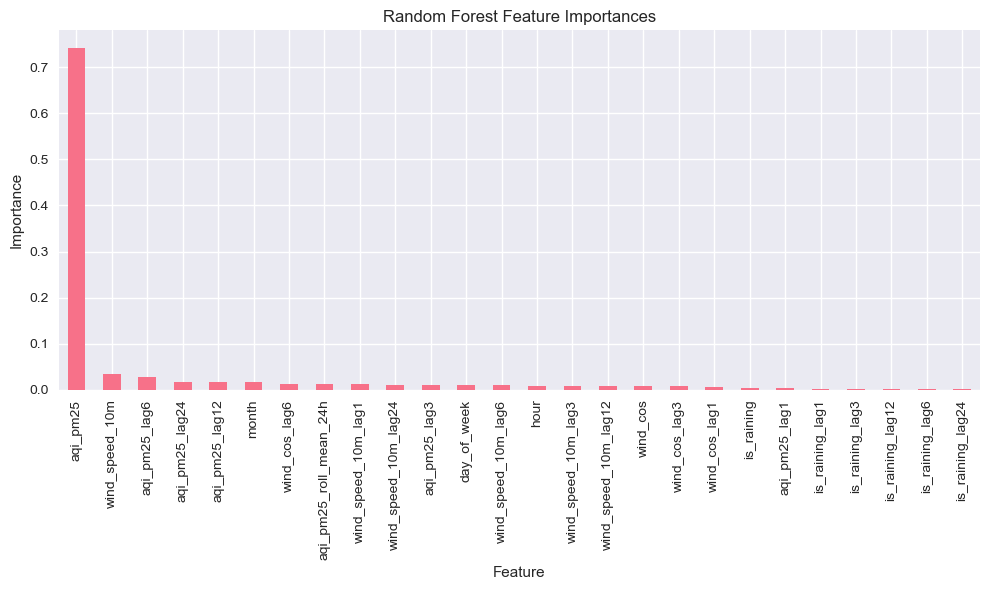

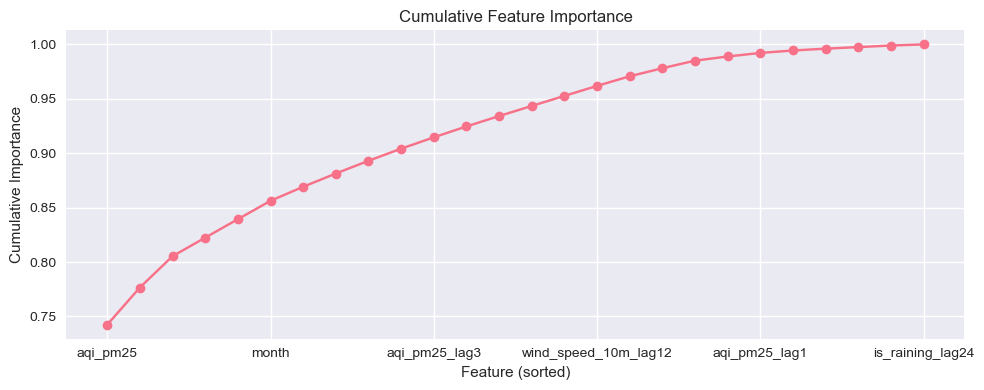

In [21]:
# get feature importances from the trained model
importances = rf.feature_importances_
fi = pd.Series(importances, index=X_train_tree.columns).sort_values(ascending=False)

# display
print(fi)

# bar plot of importances
plt.figure(figsize=(10,6))
fi.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# cumulative importance plot
plt.figure(figsize=(10,4))
fi.cumsum().plot(marker='o')
plt.title("Cumulative Feature Importance")
plt.ylabel("Cumulative Importance")
plt.xlabel("Feature (sorted)")
plt.grid(True)
plt.tight_layout()
plt.show()

(24, 23)


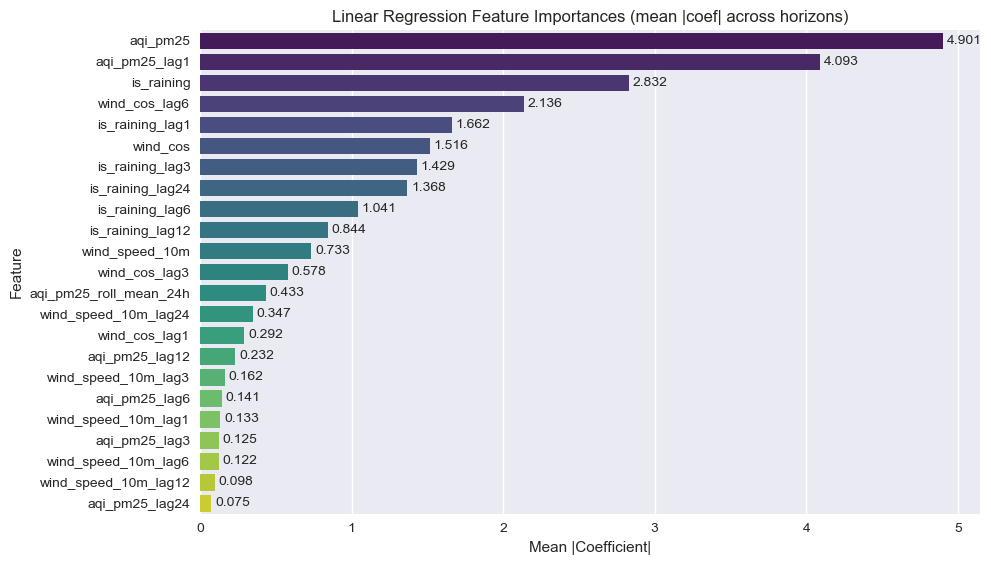

In [27]:
# Plot Linear Regression "feature importances" using mean absolute coefficients across horizons
# (works for multi-output LinearRegression)
if not hasattr(lr_model, "coef_"):
    raise AttributeError("lr_model has no coef_. Make sure the LinearRegression model is trained.")

# Get feature names used to train lr_model
try:
    feature_names = list(X_train.columns)
except NameError:
    # fallback to selected_features if X_train not available
    feature_names = selected_features

coefs = lr_model.coef_
print(coefs.shape)
# Handle single-output and multi-output shapes
if coefs.ndim == 1:
    importances = np.abs(coefs)
else:
    importances = np.mean(np.abs(coefs), axis=0)  # mean absolute coef across all horizons

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, max(4, 0.25 * len(fi))))
sns.barplot(x=fi.values, y=fi.index, palette="viridis")
plt.title("Linear Regression Feature Importances (mean |coef| across horizons)")
plt.xlabel("Mean |Coefficient|")
plt.ylabel("Feature")
plt.tight_layout()

# Annotate values on bars
for i, v in enumerate(fi.values):
    plt.text(v + fi.values.max()*0.005, i, f"{v:.3f}", va="center")

plt.show()

### SARIMAX

In [10]:
# D. SARIMAX (Level 2.1)
df_ts = df_processed.asfreq('h')
df_ts = df_ts.interpolate(method='time')

print(df_ts.shape)
print(df_ts.columns)

(28817, 73)
Index(['temperature_2m', 'relative_humidity_2m', 'rain', 'wind_direction_10m',
       'wind_speed_10m', 'aqi_pm25', 'hour', 'month', 'day_of_week',
       'is_weekend', 'is_raining', 'wind_sin', 'wind_cos', 'aqi_pm25_lag1',
       'aqi_pm25_lag3', 'aqi_pm25_lag6', 'aqi_pm25_lag12', 'aqi_pm25_lag24',
       'wind_speed_10m_lag1', 'wind_speed_10m_lag3', 'wind_speed_10m_lag6',
       'wind_speed_10m_lag12', 'wind_speed_10m_lag24', 'is_raining_lag1',
       'is_raining_lag3', 'is_raining_lag6', 'is_raining_lag12',
       'is_raining_lag24', 'relative_humidity_2m_lag1',
       'relative_humidity_2m_lag3', 'relative_humidity_2m_lag6',
       'relative_humidity_2m_lag12', 'relative_humidity_2m_lag24',
       'temperature_2m_lag1', 'temperature_2m_lag3', 'temperature_2m_lag6',
       'temperature_2m_lag12', 'temperature_2m_lag24', 'wind_sin_lag1',
       'wind_sin_lag3', 'wind_sin_lag6', 'wind_sin_lag12', 'wind_sin_lag24',
       'wind_cos_lag1', 'wind_cos_lag3', 'wind_cos_lag6', '

In [11]:
# Perform ADF test
df_pm25 = df_processed[['aqi_pm25']].copy()
adf_result = adfuller(df_pm25)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -13.507674887100901
p-value: 2.8940225466153344e-25
Critical Values: {'1%': -3.430577347689359, '5%': -2.861640481375097, '10%': -2.5668234831971772}


Generating Diagnostics Plots...


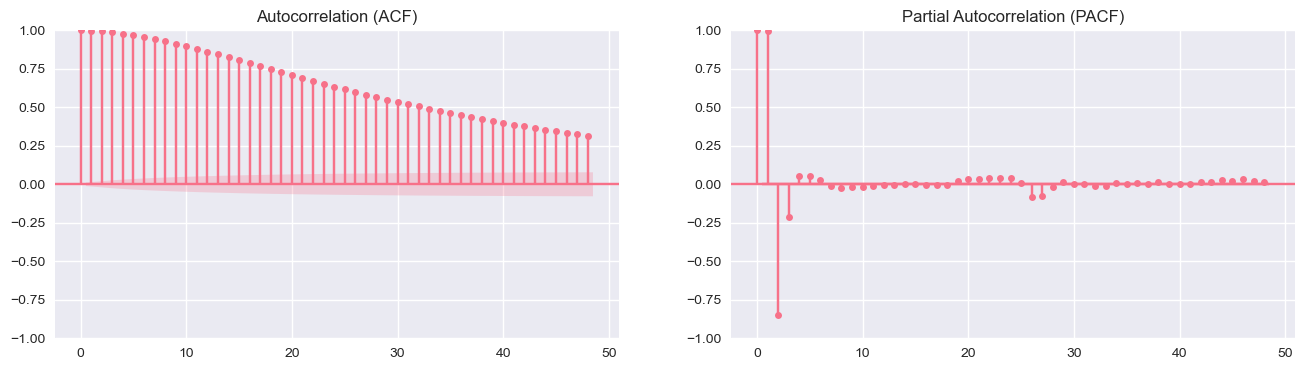

In [13]:
# We analyze the STATIONARITY and Autocorrelation
print("Generating Diagnostics Plots...")

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# Original Series
# Note: PM2.5 is usually stationary-ish, but seasonality might need differencing
plot_acf(df_ts['aqi_pm25'].dropna(), lags=48, ax=axes[0], title='Autocorrelation (ACF)')
plot_pacf(df_ts['aqi_pm25'].dropna(), lags=48, ax=axes[1], title='Partial Autocorrelation (PACF)')
plt.show()

# Interpretation:
# ACF decaying slowly -> Needs differencing or has strong trend/seasonality
# PACF cuts off after lag k -> Suggests AR(k) model

In [12]:
# Define models with 24-hour seasonality (hourly data)
from statsforecast import StatsForecast
models = [
    # AutoARIMA(season_length=24),
    AutoETS(season_length=24),
    # Naive()
]

# Initialize StatsForecast
sf = StatsForecast(
    models=models,
    freq='h',  # hourly frequency
    n_jobs=-1
)

# StatsForecast expects a DataFrame with columns 'unique_id', 'ds' (datetime) and 'y' (value).
df_sf = df_ts[['aqi_pm25']].reset_index().rename(columns={'time': 'ds', 'aqi_pm25': 'y'})
df_sf['unique_id'] = 'pm25_series'  # single series
df_sf

,ds,y,unique_id
0,2022-08-06 07:00:00,107.0,pm25_series
1,2022-08-06 08:00:00,106.0,pm25_series
2,2022-08-06 09:00:00,106.0,pm25_series
3,2022-08-06 10:00:00,105.0,pm25_series
4,2022-08-06 11:00:00,104.0,pm25_series
...,...,...,...
28812,2025-11-18 19:00:00,74.0,pm25_series
28813,2025-11-18 20:00:00,70.0,pm25_series
28814,2025-11-18 21:00:00,66.0,pm25_series
28815,2025-11-18 22:00:00,62.0,pm25_series


In [13]:
train = df_sf.iloc[:split_idx]
val = df_sf.iloc[split_idx:]

In [14]:

# Prepare exogenous X_df if any features exist (must include 'ds' column)
if len(selected_features + time_eng_cols) > 0:
    X_df = df_ts[selected_features + time_eng_cols].reset_index().rename(columns={'time': 'ds'})
else:
    X_df = None
X_df


,ds,aqi_pm25,aqi_pm25_lag1,aqi_pm25_lag3,aqi_pm25_lag6,aqi_pm25_roll_mean_24h,aqi_pm25_lag12,aqi_pm25_lag24,wind_speed_10m_lag12,wind_speed_10m_lag24,...,is_raining_lag24,is_raining_lag12,is_raining_lag6,is_raining_lag3,is_raining_lag1,is_raining,wind_cos_lag6,wind_cos_lag3,wind_cos_lag1,wind_cos
0,2022-08-06 07:00:00,107.0,106.0,103.0,96.0,101.333333,97.0,113.0,11.3,6.2,...,False,True,True,True,True,True,6.123234e-17,6.123234e-17,0.559193,0.559193
1,2022-08-06 08:00:00,106.0,107.0,105.0,98.0,101.083333,96.0,111.0,8.7,6.6,...,True,True,True,True,True,True,1.736482e-01,8.910065e-01,0.559193,0.275637
2,2022-08-06 09:00:00,106.0,106.0,106.0,100.0,100.875000,95.0,109.0,7.2,5.1,...,False,True,True,True,True,True,-1.045285e-01,5.591929e-01,0.275637,-0.224951
3,2022-08-06 10:00:00,105.0,106.0,107.0,103.0,100.750000,95.0,108.0,5.4,5.3,...,True,True,True,True,True,True,6.123234e-17,5.591929e-01,-0.224951,-0.629320
4,2022-08-06 11:00:00,104.0,105.0,106.0,105.0,100.625000,94.0,106.0,5.4,4.8,...,True,True,True,True,True,True,8.910065e-01,2.756374e-01,-0.629320,-0.601815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28812,2025-11-18 19:00:00,74.0,79.0,88.0,95.0,114.208333,109.0,151.0,13.4,8.5,...,False,True,True,True,True,True,7.313537e-01,8.571673e-01,0.927184,0.913545
28813,2025-11-18 20:00:00,70.0,74.0,84.0,93.0,111.000000,107.0,150.0,18.4,8.6,...,False,True,True,True,True,True,7.313537e-01,9.135455e-01,0.913545,0.906308
28814,2025-11-18 21:00:00,66.0,70.0,79.0,91.0,107.666667,103.0,149.0,20.5,7.5,...,False,True,True,True,True,True,7.771460e-01,9.271839e-01,0.906308,0.933580
28815,2025-11-18 22:00:00,62.0,66.0,74.0,88.0,104.208333,101.0,144.0,21.3,9.1,...,True,True,True,True,True,True,8.571673e-01,9.135455e-01,0.933580,0.956305


In [ ]:
# Train on train and get prediction on val

forecasts_sf = sf.fit(train).predict(h=24)


In [ ]:
# Forecast for the test period (24-hour horizon, rolling)
# horizon = 24
# forecasts = sf.predict(h=horizon)
# print(f"Forecast shape: {forecasts.shape}")
# print(forecasts.head())

Forecast shape: (24, 3)
     unique_id                  ds    AutoETS
0  pm25_series 2025-11-19 00:00:00  56.198104
1  pm25_series 2025-11-19 01:00:00  53.396205
2  pm25_series 2025-11-19 02:00:00  50.758796
3  pm25_series 2025-11-19 03:00:00  48.276219
4  pm25_series 2025-11-19 04:00:00  45.939385


In [18]:
forecasts_sf['AutoETS'], val['y']

(0       165.514416
 1       165.028771
 2       164.570886
 3       164.139173
 4       163.732137
            ...    
 5759    157.018117
 5760    157.018117
 5761    157.018117
 5762    157.018117
 5763    157.018117
 Name: AutoETS, Length: 5764, dtype: float64,
 23053    165.0
 23054    164.0
 23055    163.0
 23056    162.0
 23057    161.0
          ...  
 28812     74.0
 28813     70.0
 28814     66.0
 28815     62.0
 28816     59.0
 Name: y, Length: 5764, dtype: float64)

In [21]:
# Evaluate each model using the first 24-hour forecast vs first 24 test values
# For a fair comparison with other models, we compare the 24-step ahead forecast
evaluate_multi_step('StatsForecast AutoETS', np.array(val['y']), np.array(forecasts_sf['AutoETS']))


--- StatsForecast AutoETS Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 45.07    | -        | -        | -        | -        | -        | 45.07   
MAE        | 35.38    | -        | -        | -        | -        | -        | 35.38   
R2         | -1.056   | -        | -        | -        | -        | -        | -1.056  
---------------------------------------------------------------------------------------


In [ ]:
# Plot forecasts vs actuals
plt.figure(figsize=(14, 6))
x = range(horizon)

plt.plot(x, y_true_sf, 'ko-', label='Actual', linewidth=2, markersize=6)
plt.plot(x, y_pred_autoarima, 's--', label='AutoARIMA', alpha=0.8)
plt.plot(x, y_pred_autoets, '^--', label='AutoETS', alpha=0.8)
plt.plot(x, y_pred_naive, 'x--', label='Naive', alpha=0.8)

plt.xlabel('Hours Ahead')
plt.ylabel('AQI PM2.5')
plt.title('24-Hour Forecast Comparison: StatsForecast Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# F. LSTM (Deep Learning - Level 3)